## [Chapter 13] Natural Language Autocomplete

In this lab, we're going to use transformers to get autocomplete suggestions for a given term.

In [1]:
import sys
sys.path.append('..')
from aips import *

In [2]:
import pandas
import pickle
import json
import tqdm
pandas.set_option('display.max_rows', 1000)

## Load and clean the Outdoors dataset

In [3]:
#outdoors
![ ! -d 'outdoors' ] && git clone https://github.com/ai-powered-search/outdoors.git
! cd outdoors && git pull
! cd outdoors && cat outdoors.tgz.part* > outdoors.tgz
! cd outdoors && mkdir -p '../../data/outdoors/' && tar -xvf outdoors.tgz -C '../../data/outdoors/'

Already up to date.
x README.md
x concepts.pickle
x guesses.csv
x guesses_all.json
x outdoors_concepts.pickle
x outdoors_embeddings.pickle
x outdoors_golden_answers.csv
x outdoors_golden_answers.xlsx
x outdoors_golden_answers_20210130.csv
x outdoors_labels.pickle
x outdoors_question_answering_contexts.json
x outdoors_questionanswering_test_set.json
x outdoors_questionanswering_train_set.json
x posts.csv
x predicates.pickle
x pull_aips_dependency.py
x question-answer-seed-contexts.csv
x question-answer-squad2-guesses.csv
x roberta-base-squad2-outdoors/
x roberta-base-squad2-outdoors/tokenizer_config.json
x roberta-base-squad2-outdoors/special_tokens_map.json
x roberta-base-squad2-outdoors/config.json
x roberta-base-squad2-outdoors/merges.txt
x roberta-base-squad2-outdoors/training_args.bin
x roberta-base-squad2-outdoors/pytorch_model.bin
x roberta-base-squad2-outdoors/vocab.json


In [4]:
from densevectors.outdoors import *
#Transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('data/posts.csv')
print(len(outdoors_dataframe))

19585


## Make a vocabulary of all the concepts in a corpus

In [5]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')

## Listing 13.8

In [6]:
def normalize(span):
    #normalizes a noun or verb phrase
    return ' '.join([tok.lemma_.lower() for tok in span])

def yieldTuple(df,column,total=100):
    #yields a spacy nlp.pipe compliant tuple of the column text values and its dataframe row as the context
    for idx,row in df.iterrows():
        if idx<total:
            yield (row[column],idx)

def getConcepts(df,total=None,load_from_cache=True):

    if load_from_cache:
        with open('data/outdoors_concepts.pickle','rb') as fd:
            concepts = pickle.load(fd)
        with open('data/outdoors_labels.pickle','rb') as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print('Extracting concepts. This could take a while. Take a break and stretch :)')
    
    #You can limit the number of rows processed by passing in total (an integer)
    if not total:
        total = len(df)
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ['NN','NNP','NNS','NOUN'] #Nouns
    verbtags = ['VB','VBD','VBG','VBN','VBP','VBZ','VERB'] #Verbs
    matcher.add("noun_phrases", [[{"TAG":{"IN": nountags}, "IS_ALPHA": True,"OP":"+"}]])
    matcher.add("verb_phrases", [[{"TAG":{"IN": verbtags}, "IS_ALPHA": True,"OP":"+", "LEMMA":{"NOT_IN":["be"]}}]])
    for doc,idx in tqdm.tqdm(nlp.pipe(yieldTuple(df,"body",total=total), batch_size=40, n_threads=4, as_tuples=True),total=total):
        text = doc.text
        matches = matcher(doc)
        for matchid,start,end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)
            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i in range(len(phrases)):
        phrase = phrases[i]
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    with open('data/outdoors_concepts.pickle','wb') as fd:
        pickle.dump(sorted_concepts,fd)
    with open('data/outdoors_labels.pickle','wb') as fd:
        pickle.dump(labels,fd)
    
    return sorted_concepts,labels

## Listing 13.9

### Examining the vocabulary

What are the concepts with the highest frequency?

In [7]:
# Set load_from_cache=False to re-extract all the concepts from the corpus.
concepts,labels = getConcepts(outdoors_dataframe,load_from_cache=True)
topcons = {k:v for (k,v) in concepts.items() if v>5 }
print('Total number of labels:',len(labels.keys()))
print('Total number of concepts:',len(concepts.keys()))
print('Concepts with greater than 5 term frequency:',len(topcons.keys()))
print(json.dumps(topcons,indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [8]:
from sentence_transformers import SentenceTransformer, util as STutil
stsb = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

## Listing 13.10

In [9]:
def getEmbeddings(concepts,minimum_frequency,load_from_cache=True):
    phrases = [key for (key,tf) in concepts.items() if tf>=minimum_frequency]
    if not load_from_cache:
        embeddings = stsb.encode(phrases, convert_to_tensor=True)
        with open('data/outdoors_embeddings.pickle','wb') as fd:
            pickle.dump(embeddings,fd)
    else:
        with open('data/outdoors_embeddings.pickle','rb') as fd:
            embeddings = pickle.load(fd)
    return phrases,embeddings

#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6

#set load_from_cache=False to regenerate the embeddings rather than loading from pickle
phrases,embeddings = getEmbeddings(concepts,minimum_frequency, load_from_cache=True)

print('Number of embeddings:',len(embeddings))
print('Dimensions per embedding:',len(embeddings[0]))

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.11

### Explore the top similarities for the top terms

In [10]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:250], embeddings[0:250])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(phrases[a])
        b_phrases.append(phrases[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"]>0.7]

,phrase a,phrase b,score,name,idx
0,protect,protection,0.928150,similarity,0
1,climbing,climber,0.923570,similarity,1
2,camp,camping,0.878894,similarity,2
3,climb,climbing,0.833662,similarity,3
4,something,someone,0.821081,similarity,4
5,hike,hiking,0.815187,similarity,5
6,people,person,0.784663,similarity,6
7,climb,climber,0.782961,similarity,7
8,go,leave,0.770643,similarity,8
9,keep,stay,0.768612,similarity,9


## Listing 13.12

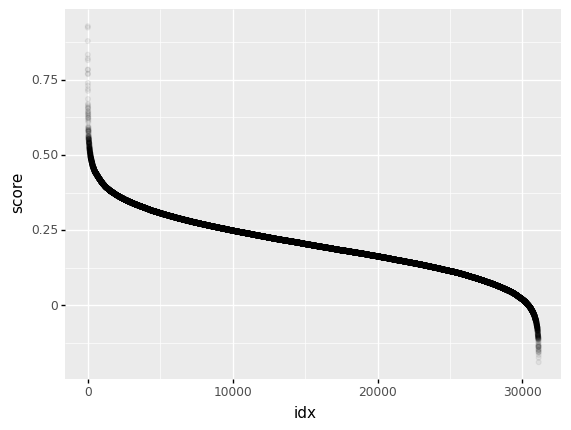

{<ggplot: (8784502692461)>}

In [11]:
from plotnine import *
#candidate_synonyms = comparisons[comparisons["score"]>0.0]
{
    ggplot(comparisons, aes('idx','score'))
    + geom_point(alpha = .05)
}

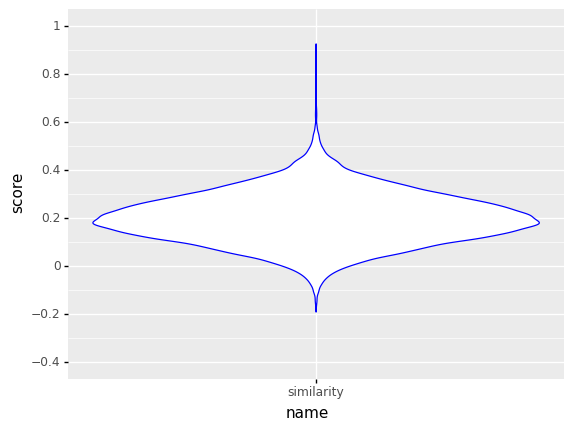

{<ggplot: (8784500645565)>}

In [12]:
#WARNING!  This produces a memory error on some Docker configurations and will reset the notebook kernel.
{
    ggplot(comparisons, aes('name','score')) +
    geom_violin(color='blue') + 
    scale_y_continuous(limits=[-0.4,1.0], breaks=[-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
}

## Listing 13.13

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [13]:
import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [labels[phrases[idx]].lower() for idx in ids]
print(matches)

['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


## Listing 13.14

In [14]:
from IPython.core.display import display,HTML
def print_labels(prefix,matches):
    display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
    for l,d in matches:
        if l in labels.keys():
            l = labels[l].lower()
        print(l + '\t' + str(d))
        
def semanticsuggest(query,k=20):
    matches = []
    embeddings = stsb.encode([query], convert_to_tensor=True)
    ids, distances = index.knnQuery(embeddings[0], k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.75:
            matches.append((text,dist))
    if not len(matches):
        matches.append((phrases[ids[1]],1.0-distances[1]))
    return matches

def autocomplete(prefix):
    matches = semanticsuggest(prefix)
    print_labels(prefix,matches)

In [15]:
autocomplete('mountain hike')

mountain hike	1.0
mountain hiking	0.9756487607955933
mountain trail	0.8470598459243774
mountain guides	0.7870422601699829
mountain terrain	0.7799180746078491
mountain climbing	0.7756213545799255
mountain ridge	0.7680723071098328
winter hikes	0.7541308999061584


In [16]:
autocomplete('campfire')

campfire	0.9999997615814209
camp fire	0.9566243886947632
campfire impacts	0.9282976388931274
camping fuels	0.8655523061752319
camping stoves	0.8239544630050659
camp stove	0.7969684600830078
cooking fires	0.7753304839134216
campground	0.7744450569152832
fireplace	0.7649710774421692
camping area	0.7596511244773865
have camped	0.7553194761276245


In [17]:
autocomplete('dehyd')

dehydrated	0.9417487382888794
dehydration	0.9317409992218018
rehydration	0.852516770362854
dehydrator	0.8514857292175293
hydration	0.8362184166908264
hydrating	0.8358256816864014
rehydrating	0.8222473859786987
hydrated	0.8123505115509033
hydration pack	0.7883822917938232
hydration system	0.7768828868865967


In [18]:
autocomplete('compa')

comp	0.8632745742797852
compact	0.8295658826828003
compiled	0.8032784461975098
compost	0.7929491996765137
compass	0.7862532138824463
competitors	0.7782407999038696
competence	0.765196681022644
compactor	0.7587993144989014
compare	0.7551059722900391


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [19]:
def buildCandidateSet(cons):
    terms = [k for (k,v) in cons.items()]
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = semanticsuggest(term,k=25)
        originals += [term]*len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({'term':originals,'candidate':candidates,'score':scores})
    return pairs

In [20]:
pairs = buildCandidateSet(topcons)
pairs.to_csv('pairs.csv')

100%|██████████| 1000/1000 [00:48<00:00, 20.58it/s]


In [21]:
#Compare a list of terms
def compare(terms):

    term_embeddings = stsb.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms)-1):
        for b in range(a+1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = STutil.pytorch_cos_sim(term_embeddings[a],term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [22]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(['man','woman','nurse practitioner','doctor'])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

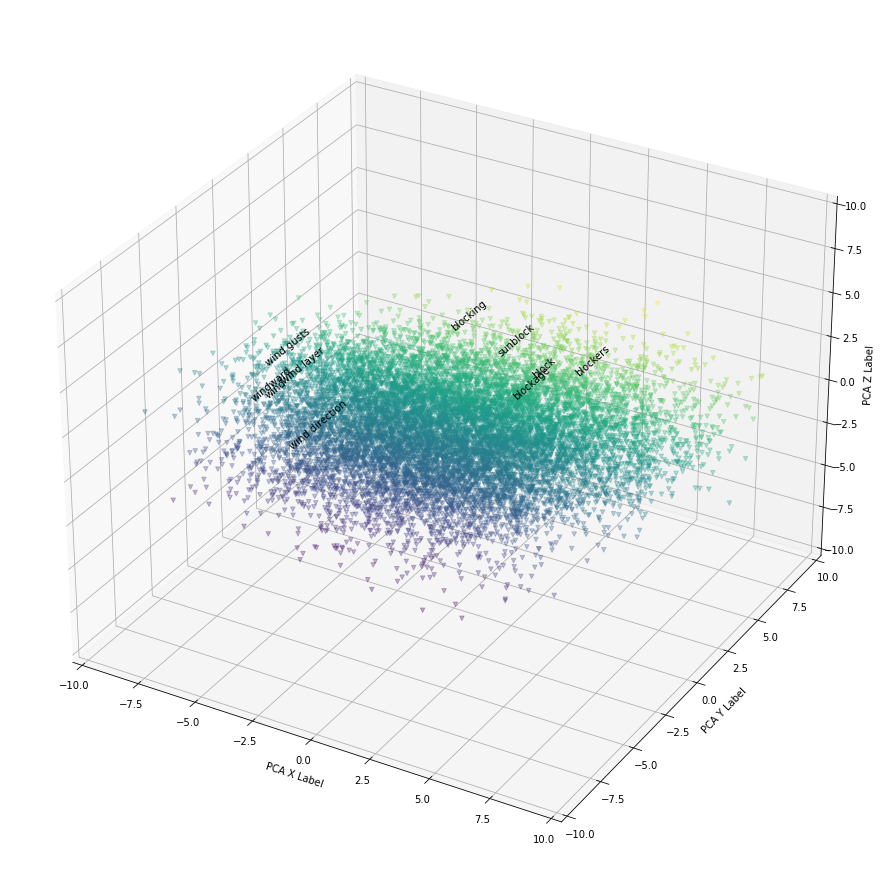

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pandas.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection='3d')
ax.scatter(
    components['x'].values, 
    components['y'].values, 
    c=components['y'].values, 
    marker='v', 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()

## Addendum: Find topic vector centroids with KMeans

In [24]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.6:
            matches.append((ids[i],text,dist))
    if not len(matches):
        matches.append(([ids[1]],phrases[ids[1]],1.0-distances[1]))
    return matches

In [25]:
def findcentroids(embeddings,n_clusters=8,max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = embeddings.numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML('<h4>Results for: <em> centroid '+str(len(centroids)-1)+'</em></h4>'))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + '\t' + l + '\t' + str(d))
    
    return centroids,torch_stack(centroid_embeddings)

In [26]:
centroids,centroid_embeddings = findcentroids(embeddings,n_clusters=100,max_iter=50)

1109	sunlight	0.8945754766464233
157	light	0.8936780691146851
6549	lightness	0.8789408802986145
927	lightning	0.8714558482170105
11942	sun light	0.8621188402175903


8227	strangled	0.7928389310836792
8398	entangled	0.7781764268875122
2190	tangled	0.7628130912780762
3692	dangling	0.7303850054740906
11150	entanglement	0.7038062810897827


3822	slit	0.7796574234962463
3042	silk	0.7793006896972656
2275	se	0.7736003398895264
11253	sls	0.7612610459327698
4789	suv	0.7502989172935486


1403	garment	0.8344687819480896
6972	gadget	0.8163374662399292
8974	gaia gps	0.7990013360977173
2398	garage	0.7835235595703125
9941	gpi	0.781685471534729


5277	overloading	0.8073946237564087
11355	large	0.7859331965446472
2362	high	0.7810285687446594
12005	heighten	0.7763227820396423
3176	maximum	0.7605316638946533


6684	trail system	0.8547019958496094
28	trail	0.8218646049499512
8176	trails	0.8205459713935852
6527	trail map	0.8172569870948792
11621	trailing	0.8160125017166138


4911	documentation	0.7447238564491272
8806	conservancy	0.7263535261154175
1772	document	0.7057943344116211
496	reported	0.6964486837387085
1603	understanding	0.6851192116737366


6763	contraction	0.7673501968383789
7600	crate	0.7651628255844116
7250	carbonate	0.7620643377304077
8033	consumables	0.7501769065856934
2484	contour	0.7477741241455078


2953	sea kayak	0.8261662721633911
9957	water boat	0.798089325428009
2188	sailboat	0.782749354839325
7004	fishing kayak	0.7776674628257751
10464	scuba dive	0.766865074634552


3381	molecules	0.7562897801399231
3134	montana	0.7388770580291748
10170	ammonium nitrate	0.7376935482025146
6978	mojave	0.732184886932373
9714	marlin	0.7270861864089966


7036	fl	0.8436285853385925
1967	flotation	0.8141059875488281
12336	fluorescent	0.8087085485458374
1677	flint	0.8083299398422241
2361	flavors	0.804423451423645


8070	body core	0.7881054282188416
9864	body types	0.7598038911819458
7407	body temp	0.7525734901428223
6280	core body	0.731345534324646
5759	body position	0.7308902740478516


5537	telephone	0.8635011911392212
3360	cellphone	0.8396386504173279
377	phone	0.8369313478469849
1747	cell phone	0.8305875062942505
11066	communication device	0.8283891081809998


6603	retirement	0.8169283866882324
50	end	0.8063842058181763
9333	ending	0.8029909133911133
7421	have ended	0.7928550839424133
8975	firing	0.791062593460083


1402	v	0.8634260892868042
5870	va	0.8502857089042664
1502	valve	0.8322285413742065
704	uv	0.8186382055282593
2139	van	0.8168851137161255


4850	penguin	0.728161096572876
8219	pinnacle	0.7216883301734924
5794	polaris	0.7182859182357788
4849	peas	0.7127004265785217
3104	pistols	0.7111000418663025


10921	proper	0.8156236410140991
8285	prevalence	0.811390221118927
2585	propose	0.778995156288147
8118	preform	0.7518503665924072
4079	promise	0.7474578619003296


278	north	0.7872778177261353
8967	recreational	0.7821846008300781
5496	creases	0.7794337868690491
287	emergency	0.7772157788276672
3848	north face	0.7726126909255981


69	ground	0.7888917922973633
5126	ground level	0.7868219614028931
9662	ground surface	0.7707706689834595
6778	ground cover	0.7539222836494446
8656	ground pad	0.7424025535583496


2865	gauge	0.7980409860610962
4663	gr	0.7946975827217102
12260	gander	0.7913389801979065
641	g	0.7726213335990906
10176	grapevine	0.7685147523880005


1928	h	0.8507652282714844
10503	hutte	0.8061617016792297
7088	hwy	0.79306960105896
4827	hace	0.7886567115783691
11818	hasten	0.7859460115432739


1701	hiking trails	0.9123026132583618
11587	hiking paths	0.9040005207061768
3025	hiking trip	0.8879930973052979
93	hiking	0.8865603804588318
8955	hiking routes	0.8840517997741699


10704	tense	0.7947965860366821
11259	timeline	0.7313034534454346
2746	condensing	0.7271863222122192
1696	lenses	0.722267746925354
8	times	0.7205233573913574


1112	s	0.817900538444519
9384	sc	0.7961042523384094
6373	sa	0.7918480634689331
2800	sar	0.7868070602416992
9077	scenic	0.7683888077735901


2413	extension	0.8216473460197449
2098	e	0.804547905921936
5884	expel	0.7905755043029785
8373	es	0.7806894779205322
10636	engraved	0.7803674936294556


11542	dnt	0.8260440826416016
4547	dent	0.8259354829788208
1852	d	0.8254033923149109
7002	delorme	0.8210561871528625
9735	duo	0.8015967607498169


806	brake	0.6610456109046936
4903	braking	0.660443902015686
353	attacks	0.6266266107559204
6416	blockers	0.6257972121238708
9051	brake side	0.6256544589996338


80	ice	0.8512914180755615
3071	ice axes	0.8450204133987427
8369	icefall	0.8169552087783813
11032	ice box	0.7974568605422974
5862	ice cubes	0.7973518371582031


866	considerations	0.7790738344192505
6446	reconsider	0.7693690061569214
5079	speculation	0.7579907178878784
2633	confusion	0.7554356455802917
4080	interpretations	0.7551515698432922


1141	headlamp	0.7350245714187622
10334	amputated	0.7174821496009827
8574	thumps	0.7089680433273315
2200	lamp	0.7073099613189697
3324	stump	0.6914099454879761


2183	ii	0.7698532342910767
4185	nz	0.7482292056083679
1880	in	0.7358309030532837
2624	i	0.7172378301620483
3801	ie	0.707227885723114


3400	rainfall	0.8535366058349609
1997	weather conditions	0.8455761075019836
10245	weathering	0.8356995582580566
2697	weather forecast	0.8245868682861328
6840	weather reports	0.821332573890686


513	man	0.789577066898346
9213	mens	0.7717435359954834
2477	father	0.7499758005142212
8184	adult male	0.732250452041626
1447	manner	0.7237082719802856


52	bears	0.8415216207504272
6637	bear boxes	0.8276796340942383
2355	bear bag	0.8223683834075928
6804	bear bangers	0.8057035803794861
1330	bear spray	0.804445743560791


2602	n	0.8518831729888916
7539	ne	0.8314250707626343
4107	ny	0.7881287932395935
11971	nestled	0.7744512557983398
10901	verne	0.7719811201095581


10283	survival tool	0.8172825574874878
9037	survival rate	0.7804650068283081
6385	survivalist	0.7767894268035889
8836	rope handling	0.7696199417114258
8799	rope strength	0.7684511542320251


53	fire	0.9294145107269287
8855	fire risk	0.8624348044395447
9178	fire way	0.852970540523529
8515	friction fires	0.8404302000999451
1404	firearm	0.8396850824356079


7466	blubber	0.8232581615447998
9204	rubble	0.8153636455535889
8988	bloqueurs	0.802986741065979
3958	blanc	0.7951822876930237
691	rubber	0.7910589575767517


11076	plastic sheet	0.7953798770904541
408	plastic	0.7789164781570435
8521	plateaus	0.7722116708755493
6894	polymer	0.7298401594161987
3020	posture	0.7295491099357605


901	water bottles	0.7900292873382568
12055	oxygen bottles	0.7857908010482788
6776	pop bottles	0.7823798060417175
6929	spray bottle	0.7797137498855591
9303	squeeze bottle	0.7790442109107971


2983	p	0.8567235469818115
9900	pipistrelle	0.8478865623474121
5761	pp	0.8367397785186768
4872	piston	0.8339189291000366
8382	prepping	0.83058762550354


7828	air force	0.8570634722709656
3081	aircrafts	0.8507124185562134
95	air	0.8497236371040344
2723	airplanes	0.8485412001609802
8746	air exchange	0.842741847038269


10466	handwashing	0.795318603515625
11868	dishwashing	0.7926886677742004
1514	wipes	0.7841882705688477
10465	rinsing	0.7780656814575195
360	washing	0.7733072638511658


5	water	0.9330457448959351
9093	watering	0.9285187125205994
7458	water systems	0.9276187419891357
2929	water temperatures	0.8954263925552368
8322	water filtration	0.8950188755989075


1728	recovery	0.7974797487258911
3253	recoiling	0.7856550812721252
1364	recover	0.7713775634765625
2060	rescuer	0.7677631378173828
7185	repack	0.7642087340354919


10391	backpack weights	0.8673979043960571
150	backpack	0.82700514793396
5341	backpack straps	0.8164210319519043
3707	pack weight	0.7782857418060303
10376	pound pack	0.7762053608894348


76	heat	0.8673735857009888
3259	heat source	0.861373782157898
8423	reheat	0.8606719970703125
9223	temperature conditions	0.8585717082023621
11873	preheating	0.8491771221160889


6103	sw	0.8472031354904175
493	swim	0.8377354145050049
10922	swift	0.821500301361084
7221	swat	0.8132487535476685
2836	swarms	0.8107367753982544


84	mountains	0.9452856183052063
11653	mountain region	0.9336070418357849
6987	mountain area	0.9167739152908325
5184	mountain national	0.915713906288147
7808	mountain project	0.9014526009559631


3471	concealed	0.7819130420684814
262	c	0.7813875675201416
9994	caverns	0.7700600624084473
11531	cary	0.7629310488700867
6263	ccs	0.7594951391220093


18	keep	0.8885963559150696
570	maintain	0.8300226926803589
7310	keep doing	0.8277988433837891
5366	have keeping	0.8095258474349976
1951	help keep	0.8061468005180359


2606	relationship	0.8452836871147156
187	couple	0.8379209637641907
4838	couple years	0.808449923992157
4754	couple times	0.796134352684021
10514	couple things	0.7883812189102173


1512	extent	0.7920812368392944
2722	evolved	0.7913091778755188
10186	outward	0.7650129795074463
2413	extension	0.7593162655830383
1321	expands	0.7577017545700073


10456	nice	0.84755539894104
3099	cleaner	0.8120136857032776
369	clean	0.8116487860679626
1261	clear	0.793665885925293
1513	ease	0.787690281867981


539	f	0.8439687490463257
12051	fcrf	0.8199955224990845
7175	fusion	0.8065340518951416
8001	ferns	0.7848904132843018
3500	fist	0.783600926399231


1718	shotgun	0.843986988067627
742	guns	0.8410754203796387
6615	gunshot	0.8252726793289185
10150	gun season	0.8124725818634033
7451	shotgun shells	0.8083924055099487


2660	dispersed	0.9087056517601013
3344	displaced	0.9051641225814819
5593	disregard	0.9017223119735718
7969	withdrawal	0.8911318182945251
1750	get rid	0.8871724009513855


8276	begs	0.8209497928619385
4410	banff	0.7956966161727905
11467	boast	0.787883460521698
4257	beast	0.7665307521820068
10886	boofe	0.7599780559539795


3501	tethered	0.8182972073554993
24	tent	0.8066989183425903
8683	tent material	0.8062865734100342
8745	tent design	0.8040663003921509
7545	tent walls	0.8020702600479126


5292	compact	0.8242010474205017
1081	compress	0.7996228933334351
345	compass	0.7773454189300537
10502	compactor	0.7696640491485596
6117	compiled	0.7629557847976685


46	food	0.9173518419265747
7376	food items	0.9015784859657288
7067	food grade	0.8738783597946167
11180	food intake	0.8676685094833374
11722	food pack	0.8632335066795349


770	skiing	0.9050850868225098
9471	ski slope	0.8981409072875977
1557	skier	0.8764029741287231
9050	at skis	0.8712000250816345
153	skiing	0.8663369417190552


1439	l	0.833672285079956
7223	laurel	0.8280676007270813
1414	lens	0.7976605892181396
5528	lukla	0.7912043333053589
10929	laos	0.7637960314750671


240	altitude	0.7160802483558655
12281	altitude data	0.7053008675575256
6679	atlas	0.6940217614173889
6959	ar	0.678780198097229
8520	altitude changes	0.6650917530059814


5610	camping area	0.9423542618751526
4416	camping sites	0.9389569163322449
10206	camping place	0.937701940536499
101	camping	0.9376333951950073
4735	camping spot	0.9286704063415527


8792	rab	0.7916949987411499
4254	robert	0.7884145379066467
5457	roaring	0.7800906896591187
12277	ro	0.7738733887672424
7849	rock type	0.7727413773536682


6570	walking shoes	0.8724968433380127
4594	walking boots	0.8168798685073853
1024	footwear	0.8026889562606812
3154	footpath	0.7910328507423401
30	feet	0.7906376719474792


758	lowering	0.8141896724700928
8259	lowering	0.8104307651519775
11847	undercut	0.8074736595153809
12012	underneath	0.8000810146331787
10980	substrate	0.7834246754646301


976	observe	0.8061665892601013
1233	o	0.7747921943664551
5426	o o	0.7631250619888306
5206	logo	0.7560606002807617
8058	ingestion	0.7527577877044678


60	climbing	0.9186283946037292
4160	climbing wall	0.890567421913147
6205	climbing grades	0.8849503993988037
8884	climbing style	0.8793356418609619
9219	climbing trip	0.8760185241699219


332	training	0.8076972365379333
9500	training courses	0.8058733940124512
8551	training program	0.8009704947471619
11182	training sessions	0.7906041145324707
8926	has taught	0.7606878280639648


442	moisture	0.7943161725997925
7202	moisture content	0.7901343703269958
10628	muscle power	0.775945782661438
439	muscles	0.7747644186019897
5977	muscle mass	0.7741833925247192


257	m	0.8523173332214355
542	mm	0.850313663482666
1528	mid	0.7983828783035278
9545	midway	0.7727424502372742
6851	multi	0.7647191286087036


135	winter	0.9552494287490845
7724	winter seasons	0.9391875267028809
4223	winter conditions	0.9373757839202881
11371	winter weather	0.9288966655731201
6105	winter months	0.8917027711868286


183	safety	0.9462101459503174
5101	safety precaution	0.940858781337738
9273	safety aspect	0.9349852204322815
6378	safety measures	0.9286904335021973
8175	safety factor	0.9219130873680115


8189	diffusion	0.8313100337982178
6206	aversion	0.8036417365074158
2970	transmission	0.7846840620040894
6899	diffuse	0.7840641736984253
12086	transducers	0.7819963097572327


1128	t	0.8745419383049011
8745	tent design	0.8600553274154663
8683	tent material	0.8564536571502686
24	tent	0.8527888655662537
11022	tso	0.8463923931121826


5319	ve slept	0.7964234352111816
2313	retreating	0.793643593788147
62	sleeping	0.793196439743042
5775	silence	0.7907706499099731
10115	sleeping area	0.7890028953552246


5620	viewing	0.8385903239250183
4103	insight	0.8312902450561523
9587	viewer	0.8278335332870483
6219	watching	0.8003485202789307
7240	eyesight	0.79594886302948


3472	k	0.8099653720855713
7389	ken	0.783822774887085
11750	karen	0.7529891133308411
3358	trekkers	0.7450528144836426
4272	kettle	0.740228533744812


4355	polypro	0.8542214632034302
1441	polyester	0.8364450931549072
12116	polypro top	0.8329082727432251
2641	polypropylene	0.8191805481910706
4731	polyurethane	0.8097794055938721


41	start	0.9020993709564209
4170	get started	0.8878239393234253
4157	have started	0.8872625231742859
578	begins	0.8862862586975098
1574	beginning	0.8847513198852539


8092	payment	0.7807207107543945
7334	price tag	0.7663925886154175
610	price	0.7302033305168152
11647	refund	0.7239673137664795
3980	discounting	0.7172303199768066


898	b	0.8747380375862122
11190	ba	0.8448810577392578
3410	barb	0.8383907079696655
6818	basal	0.8246976137161255
11862	basalt	0.8143418431282043


4283	st	0.8343466520309448
4399	stern	0.7764054536819458
11892	steck	0.7541282176971436
1123	stings	0.7380426526069641
5508	sternum	0.7198982834815979


628	cooking	0.8307031989097595
11580	cooking time	0.826128363609314
10797	cooking area	0.8237626552581787
2947	cooker	0.8095830678939819
374	cook	0.7956140041351318


4317	union	0.7325165271759033
160	group	0.7277172207832336
9886	groupings	0.7221049070358276
4549	group member	0.7182798385620117
12063	family groups	0.7119658589363098


1396	r	0.8298084735870361
721	re	0.8224858045578003
4089	reps	0.7796369194984436
2665	residue	0.7741425633430481
12307	reserved	0.772598147392273


11151	get sucked	0.7569568157196045
613	trouble	0.756129264831543
5130	shame	0.7497236132621765
2184	distress	0.7375165224075317
8607	bear problems	0.7324692010879517


2079	has got	0.7699881792068481
2173	had become	0.7666142582893372
5495	have occurred	0.7474382519721985
6860	go getting	0.7296328544616699
8318	makes getting	0.7285885810852051


881	have had	0.8142198324203491
0	have	0.806133508682251
11959	remember having	0.8038043975830078
6587	seen have	0.797121524810791
11296	have seen have	0.786036491394043


255	rescue	0.8623611927032471
8199	rescue situations	0.8488842844963074
9058	rescue work	0.8345021605491638
5733	rescue operation	0.8243423700332642
4987	rescue service	0.8145251274108887


2033	wilderness area	0.8640121817588806
309	wilderness	0.854150652885437
6035	wildland	0.8489028215408325
10394	wild country	0.8461508750915527
12293	wildlife habitat	0.840377151966095


205	increased	0.8650598526000977
8363	revised	0.8553248643875122
947	advise	0.8441895842552185
6567	increments	0.834561824798584
3651	enhance	0.8065827488899231


2245	w	0.8538219332695007
5826	wa	0.8396890163421631
11220	wy	0.8242826461791992
802	west	0.822589099407196
12166	wren	0.8188943862915039


1538	spine	0.8703018426895142
11135	sp	0.8439286351203918
3987	spices	0.8427361845970154
9668	spasm	0.8098305463790894
2811	spitting	0.8096530437469482


2182	coconut	0.8104767799377441
5081	cocoon	0.8012445569038391
6184	coke	0.7782482504844666
10635	coconut shell	0.7719353437423706
3821	colonies	0.7572180032730103


4487	tree branches	0.8667088150978088
61	tree	0.8665446043014526
9533	trees limbs	0.8511949181556702
9226	tree cover	0.8503337502479553
12089	tree stumps	0.8450926542282104


10932	geotagged	0.846355140209198
10019	geotags	0.8072091937065125
2885	georgia	0.8070178031921387
3883	genera	0.8049848079681396
6004	noggins	0.7962630987167358


59	snow	0.9354913830757141
9459	snow level	0.9330682754516602
4232	snow conditions	0.8951126337051392
10811	snow line	0.8945882320404053
3809	snowfall	0.8922396898269653


In [27]:
print(centroids)
print(centroid_embeddings)

[(1109, 'sunlight', 0.8945754766464233), (8227, 'strangle', 0.7928389310836792), (3822, 'slit', 0.7796574234962463), (1403, 'garment', 0.8344687819480896), (5277, 'overload', 0.8073946237564087), (6684, 'trail system', 0.8547019958496094), (4911, 'documentation', 0.7447238564491272), (6763, 'contraction', 0.7673501968383789), (2953, 'sea kayak', 0.8261662721633911), (3381, 'molecule', 0.7562897801399231), (7036, 'fl', 0.8436285853385925), (8070, 'body core', 0.7881054282188416), (5537, 'telephone', 0.8635011911392212), (6603, 'retirement', 0.8169283866882324), (1402, 'v', 0.8634260892868042), (4850, 'penguin', 0.728161096572876), (10921, 'proper', 0.8156236410140991), (278, 'north', 0.7872778177261353), (69, 'ground', 0.7888917922973633), (2865, 'gauge', 0.7980409860610962), (1928, 'h', 0.8507652282714844), (1701, 'hiking trail', 0.9123026132583618), (10704, 'tense', 0.7947965860366821), (1112, 's', 0.817900538444519), (2413, 'extension', 0.8216473460197449), (11542, 'dnt', 0.826044082

In [28]:
from sentence_transformers import util as STutil
similarities = STutil.pytorch_cos_sim(centroid_embeddings, centroid_embeddings)
print('The shape of the resulting similarities:',similarities.shape)

The shape of the resulting similarities: torch.Size([100, 100])


### KMeans Topic distribution

This cell below shows good distribution of similarity scores for our topics.

In [29]:
import pandas

a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(centroids[a][1])
        b_phrases.append(centroids[b][1])
        scores.append(float(similarities[a][b]))

df = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores})
df.sort_values(by=["score"],ascending=False,ignore_index=True)

,phrase a,phrase b,score
0,extension,extent,0.876332
1,rab,r,0.748148
2,gauge,geotagge,0.741036
3,tether,t,0.732801
4,winter,snow,0.719569
...,...,...,...
4945,sea kayak,man,-0.145497
4946,camping area,t,-0.173272
4947,air force,walking shoe,-0.175434
4948,have sleep,start,-0.190825
